## Récupération et préparation des données


In [2]:
from fredapi import Fred
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
import re
import requests

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from typing import List, Dict
import os


from skfin.dataloaders.cache import CacheManager


/Users/alexd/PycharmProjects/ML for PM/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_fred_md():
    # Dataset principal
    url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
    df = pd.read_csv(url_data, index_col=0)

    # Conversion de l'index en dates si possible
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass
    
    return df

def load_transform_codes():
    url_codes = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/FRED-MD_updated_appendix.csv"
    # cp1252 (a.k.a. windows-1252) fixes the 0x92 decode error
    return pd.read_csv(url_codes, encoding="cp1252")  # or encoding="latin1"


# Chargement des deux fichiers
df = load_fred_md()
transform_codes = load_transform_codes()

df.head(), transform_codes.head()

(                 RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx      RETAILx  \
 sasdate                                                                    
 Transform:     5.000      5.0            5.000       5.0000      5.00000   
 1/1/1959    2583.560   2426.0           15.188  276676.8154  17689.23968   
 2/1/1959    2593.596   2434.8           15.346  278713.9773  17819.01912   
 3/1/1959    2610.396   2452.7           15.491  277775.2539  17967.91336   
 4/1/1959    2627.446   2470.0           15.435  283362.7075  17978.97983   
 
              INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...  \
 sasdate                                                   ...   
 Transform:   5.0000   5.0000   5.0000   5.0000    5.0000  ...   
 1/1/1959    21.9616  23.3868  22.2620  31.6664   18.9498  ...   
 2/1/1959    22.3917  23.7024  22.4549  31.8987   19.0492  ...   
 3/1/1959    22.7142  23.8459  22.5651  31.8987   19.4223  ...   
 4/1/1959    23.1981  24.1903  22.8957  32.4019   19.5466  ... 

In [4]:
CACHE_DIR = Path("data")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

cm = CacheManager(cache_dir=CACHE_DIR)

FILENAME = CACHE_DIR / "FRED_MD.parquet"

# Sauvegarde correcte des deux DataFrames
cm.save_to_cache(df, FILENAME)

In [5]:
print("\nTypes de données :")
print(df.dtypes)

# Vérification des doublons
n_duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {n_duplicates}")
 
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Types de données :
RPI                float64
W875RX1            float64
DPCERA3M086SBEA    float64
CMRMTSPLx          float64
RETAILx            float64
                    ...   
UMCSENTx           float64
DTCOLNVHFNM        float64
DTCTHFNM           float64
INVEST             float64
VIXCLSx            float64
Length: 126, dtype: object

Nombre de lignes dupliquées : 0

Valeurs manquantes par colonne :


CMRMTSPLx          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      2
S&P PE ratio       1
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         154
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64

Dans un premier temps, nous avons inspecté la base de données afin d’identifier la présence éventuelle de doublons ainsi que le taux de valeurs manquantes par série. 

Pour garantir un panel cohérent et exploitable en analyse factorielle et en apprentissage statistique, nous avons effectué les étapes suivantes :
- Restriction de l’échantillon à la période 1962-05 à 2025-07 : on élimine les observations trop anciennes ou trop récentes où plusieurs variables ne sont pas encore disponibles. Cela réduit l’impact des fortes valeurs manquantes en début et fin de série
- Suppression de quatre variables qui contiennent trop peu d’observations. 

In [6]:
# 1) Conversion obligatoire de l’index en datetime
df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()

# 2) Coupe du dataset
df = df.loc[df.index >= "1962-05-01"]
# 2) Coupe du dataset
df = df.loc[df.index <= "2025-07-01"]

cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Valeurs manquantes par colonne :


S&P div yield    1
CP3Mx            1
COMPAPFFx        1
VIXCLSx          2
dtype: int64

La variable VIX présente deux valeurs manquantes, que nous pouvons pour le moment nous permetre de conserver puisque cette variable ne subit pas de transformation (t-code 1), ces deux variables disparaitront lorsque nous enleverons les Na apprès la transformation des autres varibales. 

A part le VIX, il ne reste plus que trois valeurs manquantes dans le dataframe, nous les remplassons par la dernière valeur connue.

In [7]:
df = df.ffill()

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Valeurs manquantes par colonne :


VIXCLSx    2
dtype: int64

In [8]:
print("\nInfo générale :")
df.info()
 
print("\nStatistiques descriptives :")
display(df.describe().T)
display(df.tail())
display(df.head())


Info générale :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 759 entries, 1962-05-01 to 2025-07-01
Columns: 122 entries, RPI to VIXCLSx
dtypes: float64(98), int64(24)
memory usage: 729.4 KB

Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,max
RPI,759.0,10040.682422,5034.739208,2941.67800,5683.906500,8817.4050,1.387240e+04,2.291842e+04
W875RX1,759.0,8531.016206,3972.176307,2752.90000,5037.150000,7574.1000,1.171765e+04,1.673990e+04
DPCERA3M086SBEA,759.0,59.455592,30.515542,17.08000,32.707500,52.4470,8.512850e+01,1.243700e+02
CMRMTSPLx,759.0,860343.202941,378124.916363,291713.95990,523828.901500,776545.9350,1.205385e+06,1.565742e+06
RETAILx,759.0,233675.247674,190294.055417,19433.71682,63887.199675,179758.0000,3.618745e+05,7.274140e+05
...,...,...,...,...,...,...,...,...
CES3000000008,759.0,12.414545,7.146700,2.26000,5.870000,11.8800,1.839500e+01,2.901000e+01
DTCOLNVHFNM,759.0,150242.594941,146627.298777,7106.00000,14178.000000,88311.6500,2.740593e+05,5.597089e+05
DTCTHFNM,759.0,378395.731792,341224.985587,15968.00000,38060.500000,213063.0900,7.333142e+05,9.493062e+05
INVEST,759.0,1443.307403,1542.107741,86.65780,235.226000,885.4433,2.288331e+03,5.846708e+03


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
2025-03-01,20547.128,16695.4,123.575,1563633.0,722572.0,103.5408,101.5515,101.2219,101.8943,102.4664,...,105.550,119.757,131.519,32.19,36.80,28.88,554966.69,938997.88,5432.5721,21.6579
2025-04-01,20698.762,16739.9,123.748,1555663.0,721789.0,103.6224,101.3671,101.1112,101.6979,101.0930,...,106.066,119.658,131.767,32.22,36.96,28.78,554180.13,940362.47,5500.0706,32.5116
2025-05-01,20581.743,16703.7,123.575,1550522.0,716101.0,103.6570,101.4038,101.1856,101.5808,102.5239,...,106.088,119.780,132.071,32.31,37.08,28.87,551829.26,938763.49,5526.3170,20.3620
2025-06-01,20575.971,16664.7,123.894,1556845.0,723033.0,104.2115,101.7271,101.5445,101.9628,101.0181,...,106.590,120.208,132.386,32.40,37.23,28.94,549682.41,937344.92,5555.2136,18.3246
2025-07-01,20625.729,16718.9,124.370,1565742.0,727414.0,103.8194,101.4573,101.4961,101.7345,100.6594,...,106.471,120.036,132.778,32.47,37.28,29.01,547389.12,934567.19,5585.9624,16.4718


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-05-01,2941.678,2752.9,17.166,295631.7077,19686.23341,25.2141,27.0598,25.9815,36.7377,23.1525,...,63.848,18.735,10.948,2.38,2.86,2.27,7106.0,15968.0,86.6578,NaN
1962-06-01,2945.739,2756.3,17.080,293308.8034,19433.71682,25.1604,27.0885,25.9540,36.5054,22.7298,...,64.048,18.702,10.968,2.38,2.87,2.26,7242.0,16228.0,87.4133,NaN
1962-07-01,2960.008,2769.4,17.135,291713.9599,19741.56573,25.4023,27.3468,26.2846,37.1248,23.2271,...,64.096,18.645,10.979,2.39,2.90,2.27,7344.0,16453.0,87.7873,19.5715
1962-08-01,2964.773,2772.5,17.183,298514.3889,19864.30287,25.4292,27.3468,26.2295,36.6989,22.9038,...,64.104,18.696,10.989,2.40,2.90,2.28,7442.0,16685.0,87.8828,15.7942
1962-09-01,2966.166,2775.8,17.375,293815.9271,19923.65936,25.5905,27.5190,26.3397,36.9312,23.2023,...,64.159,18.913,10.997,2.40,2.91,2.28,7407.0,16758.0,88.2080,18.3148


In [9]:
# Harmoniser noms des colonnes du df
df.columns = df.columns.str.upper().str.replace("X$", "", regex=True)

# Harmoniser noms de la colonne 'fred'
transform_codes['fred'] = transform_codes['fred'].str.upper()

# Mettre 'fred' comme index pour lookup direct
transform_codes = transform_codes.set_index('fred')

df_transformed = pd.DataFrame(index=df.index)


for col in df.columns:
    if col not in transform_codes.index:
            # pas de mapping → on laisse tel quel
        s = df[col]
    else:
        code = int(transform_codes.loc[col, "tcode"])
        s = df[col]

        if code == 1:
            s = s
        elif code == 2:
            s = s.diff()
        elif code == 3:
            s = s.diff().diff()
        elif code == 4:
            # log niveau → attention aux valeurs <= 0
            s = s.where(s > 0).apply(np.log)
        elif code == 5:
            s = s.where(s > 0).apply(np.log).diff()
        elif code == 6:
            s = s.where(s > 0).apply(np.log).diff().diff()
        else:
        # codes atypiques (ex. 7) → on laisse tel quel
            s = s

    df_transformed[col] = s    

# Aperçu
df_transformed.head()

/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_17417/1063616935.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_17417/1063616935.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_17417/1063616935.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-05-01,NaN,NaN,NaN,295631.7077,19686.23341,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-06-01,0.001380,0.001234,-0.005022,293308.8034,19433.71682,-0.002132,0.001060,-0.001059,-0.006343,-0.018426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07-01,0.004832,0.004741,0.003215,291713.9599,19741.56573,0.009568,0.009490,0.012657,0.016825,0.021643,...,-0.002378,-0.001289,-0.000823,0.004193,0.006908,0.008830,-0.004972,-0.002382,-0.004411,19.5715
1962-08-01,0.001608,0.001119,0.002797,298514.3889,19864.30287,0.001058,0.000000,-0.002098,-0.011538,-0.014017,...,-0.000624,0.005784,-0.000092,-0.000018,-0.010399,-0.000019,-0.000730,0.000233,-0.003182,15.7942
1962-09-01,0.000470,0.001190,0.011112,293815.9271,19923.65936,0.006323,0.006277,0.004193,0.006310,0.012949,...,0.000733,0.008808,-0.000183,-0.004175,0.003442,-0.004396,-0.017970,-0.009637,0.002606,18.3148


In [10]:
# 2) Coupe du dataset
df_transformed = df_transformed.loc[df_transformed.index >= "1962-07-01"]

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df_transformed.isna().sum()
display(missing[missing > 0])

print(df_transformed.info())


Valeurs manquantes par colonne :


Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 1962-07-01 to 2025-07-01
Columns: 122 entries, RPI to VIXCLS
dtypes: float64(121), int64(1)
memory usage: 727.4 KB
None


In [11]:
split_date = "2016-01-01"
train = df_transformed.loc[:split_date].copy()
test  = df_transformed.loc[split_date:].copy()


Une normalisation des données est nécessaire avant une Analyse en Composante Principale. Le test set est standardisé sur les moments du train set.

In [12]:
scaler = StandardScaler()

train_std = pd.DataFrame(
    scaler.fit_transform(train),
    index=train.index,
    columns=train.columns
)

test_std = pd.DataFrame(
    scaler.transform(test),
    index=test.index,
    columns=test.columns
)

all_std = pd.DataFrame(scaler.transform(df_transformed),index = df_transformed.index,columns=df_transformed.columns)

Composantes retenues : 16
Variance expliquée cumulée : 80.46%
Outliers détectés : 33 / 757 (4.36% sur les lignes valides)


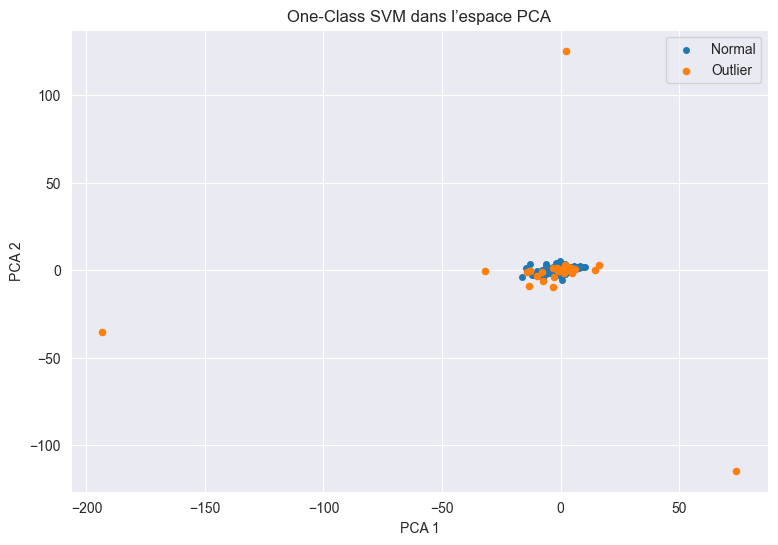

,ocsvm_score,ocsvm_is_outlier
sasdate,,
1962-07-01,0.706609,False
1962-08-01,0.609909,False
1962-09-01,0.828916,False
1962-10-01,0.641715,False
1962-11-01,0.558769,False


In [33]:
# ============================================
# PCA (sur all_std déjà standardisé) + One-Class SVM
# ============================================

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# --- 0) Données : all_std est déjà standardisé ---
X = all_std.select_dtypes(include=[np.number]).copy()

# Option: si NaN résiduels -> on retire les lignes (sinon PCA/OCSVM plante)
mask_valid = X.notna().all(axis=1)
X_clean = X[mask_valid]

# --- 1) PCA : on conserve 95% de variance (ou fixe n_components si besoin) ---
pca = PCA(n_components=0.80, random_state=42)
X_pca = pca.fit_transform(X_clean.values)

print(f"Composantes retenues : {pca.n_components_}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")

# --- 2) One-Class SVM (nu = fraction max d'outliers attendue) ---
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.04)
ocsvm.fit(X_pca)

# --- 3) Prédictions ---
# 1 = inlier, -1 = outlier
y_hat = ocsvm.predict(X_pca)
is_outlier = (y_hat == -1)

# score = decision_function : >0 inlier, <0 outlier (plus négatif = plus atypique)
scores = ocsvm.decision_function(X_pca)

# --- 4) Remise en index complet (lignes invalides marquées NaN/False) ---
res = pd.DataFrame(index=X.index, data={
    "ocsvm_score": np.nan,
    "ocsvm_is_outlier": False
})
res.loc[X_clean.index, "ocsvm_score"] = scores
res.loc[X_clean.index, "ocsvm_is_outlier"] = is_outlier

print(f"Outliers détectés : {res['ocsvm_is_outlier'].sum()} / {mask_valid.sum()} "
      f"({100 * res['ocsvm_is_outlier'].mean():.2f}% sur les lignes valides)")

# --- 5) Visualisation (PCA 2D) ---
if pca.n_components_ >= 2:
    plt.figure(figsize=(9, 6))
    plt.scatter(X_pca[~is_outlier, 0], X_pca[~is_outlier, 1], s=16, label='Normal')
    plt.scatter(X_pca[ is_outlier, 0], X_pca[ is_outlier, 1], s=20, label='Outlier')
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.title('One-Class SVM dans l’espace PCA')
    plt.legend(); plt.grid(True); plt.show()

res.head()


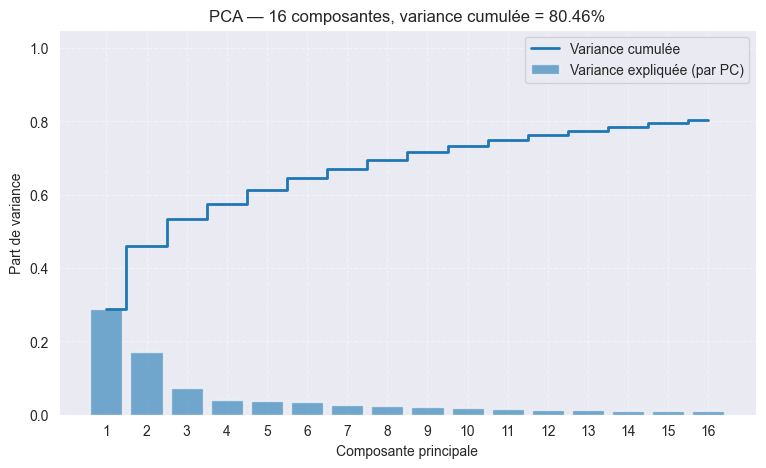

In [34]:
# ================================
# Scree plot + variance cumulée
# ================================
import numpy as np
import matplotlib.pyplot as plt

evr = pca.explained_variance_ratio_                  # part de variance par composante
evr_cum = np.cumsum(evr)                             # variance expliquée cumulée
k = pca.n_components_

plt.figure(figsize=(9, 5))
# Barres: variance par composante
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Variance expliquée (par PC)')
# Ligne: variance cumulée
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0, label='Variance cumulée')

plt.xlabel('Composante principale')
plt.ylabel('Part de variance')
plt.title(f'PCA — {k} composantes, variance cumulée = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))  # graduations raisonnables
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()


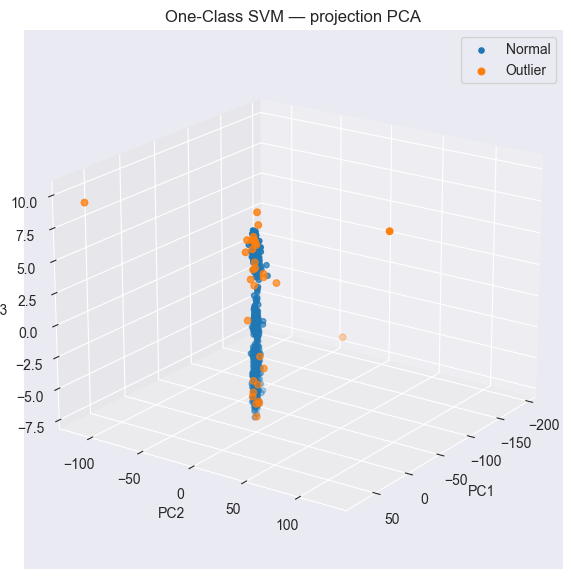

In [36]:
# =========================================
# Scatter 3D PCA (PC1, PC2, PC3)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (active le backend 3D)

if pca.n_components_ >= 3:
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    idx_in  = ~is_outlier
    idx_out =  is_outlier

    ax.scatter(X_pca[idx_in, 0],  X_pca[idx_in, 1],  X_pca[idx_in, 2],
               s=14, depthshade=True, label='Normal')
    ax.scatter(X_pca[idx_out, 0], X_pca[idx_out, 1], X_pca[idx_out, 2],
               s=22, depthshade=True, label='Outlier')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('One-Class SVM — projection PCA')
    ax.view_init(elev=20, azim=35)
    ax.grid(True)
    ax.legend()
    plt.show()
    plt.close()
else:
    print("Moins de 3 composantes : impossible de faire le scatter 3D.")
